In [ ]:
import numpy as np
import pandas as pd
import os
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
# matplotlib.use('tkagg')  # for interactive windows plt.show()
import seaborn as sns
import pingouin as pg

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression 
from scipy.stats import shapiro, friedmanchisquare, rankdata, ranksums
import statsmodels.api as sm
from statsmodels.formula.api import ols

#0- import data & apply filters
path_data = os.path.join(os.getcwd(), 'actiwear_20241017.csv')
df=pd.read_csv(path_data)
df['StepTotal'] = df['StepTotal'].fillna(0).astype(int) #we are not interested in decimals
df['Calories'] = df['Calories'].fillna(0).astype(int) #we are not interested in decimals
df['Date'] = pd.to_datetime(df['Date'])
df["ID"] = df["ID"].str[:3]
df = df.dropna(subset=['Date'])
df = df.dropna(subset=['DeviceName'])
df = df.set_index('Date')
df.head()


,ID,TotalMinutesWearTime,HR-worn,Calories,hourAboveRMR,Cal-worn(per-hour),nMinAboveRMR,Cal-worn,day/min_calory_alignment,day/min_step_alignment,StepTotal,Stepped,SyncDateUTC,Provider,DeviceName,time_diff,data_loss_risk
Date,,,,,,,,,,,,,,,,,
2020-10-22,001,0,False,2451,18,True,891,True,True,True,16193,True,10/22/2020 20:19,Fitbit,Alta,0,False
2020-10-23,001,0,False,1907,13,True,365,False,True,True,8990,True,10/23/2020 11:27,Fitbit,Alta,0,False
2020-10-24,001,0,False,2096,14,True,437,False,True,True,12425,True,10/24/2020 6:58,Fitbit,Alta,0,False
2020-10-25,001,0,False,1993,13,True,558,False,True,True,9610,True,10/25/2020 10:34,Fitbit,Alta,0,False
2020-10-28,001,0,False,1815,13,True,471,False,True,True,6393,True,10/28/2020 12:16,Fitbit,Alta,2,False


Number of steps realised ('Steps') and calories spend ('Calories') for each day of observation ('Date') of each participant ('ID'). In addition, the data contains the filters applied: 1 step and 1 calories in the whole day ('oneStep' and 'oneCalorie'), difference between min-per-min and daily data ('dataLostSynch'), tracker with heart rate acquisition ('DeviceName' and 'measuredHR'). At last, the different filters for valid wear for each days based on our software ('Method1', 'Method2' and 'MethodHR').

# 1- Descriptive Statistics

In [9]:
#1- Number of days of observation per individual 
days_per_id = df.groupby('ID').size()
weeks_per_id = days_per_id / 7
mean_days = days_per_id.mean()
std_days = days_per_id.std()
mean_weeks = weeks_per_id.mean()
std_weeks = weeks_per_id.std()

print('Before any filters')
print(f"Number of days of observation per participants: {mean_days:.2f} +/- {std_days:.2f}")
print(f"Number of weeks of observation per participants: {mean_weeks:.2f} +/- {std_weeks:.2f}")
print('')

#2- Number of days and of participants considered depending on filters applied
print(f"Raw data: ..........................................{len(df)} days, {df['ID'].nunique()} participants")
print(df.describe().round(2))
print('')
# days measured with trackers containing HR lens, i.e. Alta HR or Inspire 2
mask_device = (df['DeviceName'] == 'Alta HR') | (df['DeviceName'] == 'Inspire 2')
df_filtered = df[mask_device]
print(f"Correct trackers (Alta HR or Inspire 2):...........{len(df_filtered)} days, {df_filtered['ID'].nunique()} participants")
print(df_filtered.describe().round(2))
print('')
# days with one step and one calorie reccorded
mask_1step = df_filtered['Stepped'] == True
df_filtered = df_filtered[mask_1step]
print(f"One step recorded:..................{len(df_filtered)} days, {df_filtered['ID'].nunique()} participants")
print(df_filtered.describe().round(2))
print('')
# days with no difference between min-per-min and daily data
mask_diff = df_filtered['day/min_calory_alignment'] == True
df_filtered = df_filtered[mask_diff]
print(f"No difference between min-per-min and daily data: ...{len(df_filtered)} days, {df_filtered['ID'].nunique()} participants")
print(df_filtered.describe().round(2))
print('')

df_final = df_filtered

# days with valid wear according to Cal-worn (former Method1)
mask_method1 = df_filtered['Cal-worn'] == True
df_filtered1 = df_filtered[mask_method1]
print(f"Valid wear according to method1 (Cal-worn):....................{len(df_filtered1)} days, {df_filtered1['ID'].nunique()} participants")
print(df_filtered1.describe().round(2))
print('')
# days with valid wear according to Cal-worn (per hour) (former Method2)
mask_method2 = df_filtered['Cal-worn(per-hour)'] == True
df_filtered2 = df_filtered[mask_method2]
print(f"Valid wear according to method2 (Cal-worn (per hour)):.....................{len(df_filtered2)} days, {df_filtered2['ID'].nunique()} participants")
print(df_filtered2.describe().round(2))
print('')
# days with valid wear according to methodHR 
mask_methodHR = df_filtered['HR-worn'] == True
df_filteredHR = df_filtered[mask_methodHR]
print(f"Valid wear according to methodHR (HR-worn):....................{len(df_filteredHR)} days, {df_filteredHR['ID'].nunique()} participants")
print(df_filteredHR.describe().round(2))
print('')


Before any filters
Number of days of observation per participants: 49.57 +/- 34.10
Number of weeks of observation per participants: 7.08 +/- 4.87

Raw data: ..........................................6147 days, 124 participants
       TotalMinutesWearTime  Calories  hourAboveRMR  nMinAboveRMR  StepTotal  \
count               6147.00   6147.00       6147.00       6147.00    6147.00   
mean                 566.87   2433.22         18.14        607.31    9082.04   
std                  593.65    609.22          6.32        254.18    5444.75   
min                    0.00   1189.00          0.00          0.00       0.00   
25%                    0.00   2004.00         14.00        462.00    5375.00   
50%                  360.00   2353.00         20.00        650.00    8658.00   
75%                 1236.50   2756.00         24.00        785.00   11955.00   
max                 1440.00   6394.00         24.00       1439.00   40855.00   

       time_diff  
count    6147.00  
mean        0.

# 2- Analytic Statistics
## 2.1- Categorial approach

In [10]:
#1- Agreement rates

validWearColumns = ['Cal-worn', 'Cal-worn(per-hour)']
y_true = df_final['HR-worn'].astype(int)  # Convert boolean to binary (0 or 1)

for column in validWearColumns:
    y_pred = df_final[column].astype(int)  # Convert boolean to binary (0 or 1)
    agreement_count = df_final[(y_true == 1) & (y_pred == 1)].shape[0]
    total_count = df_final.shape[0]

    # Agreement rate
    agreement_rate = (agreement_count / total_count) * 100
    print(f" Between 'HR-worn' and '{column}' = {agreement_rate:.2f}%")
    print(f"Agreement rate: {agreement_rate:.2f}%")

    # Accuracy, precision, recall, and F1-score
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-score: {f1:.2f}")
    print("")


 Between 'HR-worn' and 'Cal-worn' = 71.90%
Agreement rate: 71.90%
Accuracy: 0.83
Precision: 0.96
Recall: 0.84
F1-score: 0.89

 Between 'HR-worn' and 'Cal-worn(per-hour)' = 85.98%
Agreement rate: 85.98%
Accuracy: 0.91
Precision: 0.91
Recall: 1.00
F1-score: 0.95



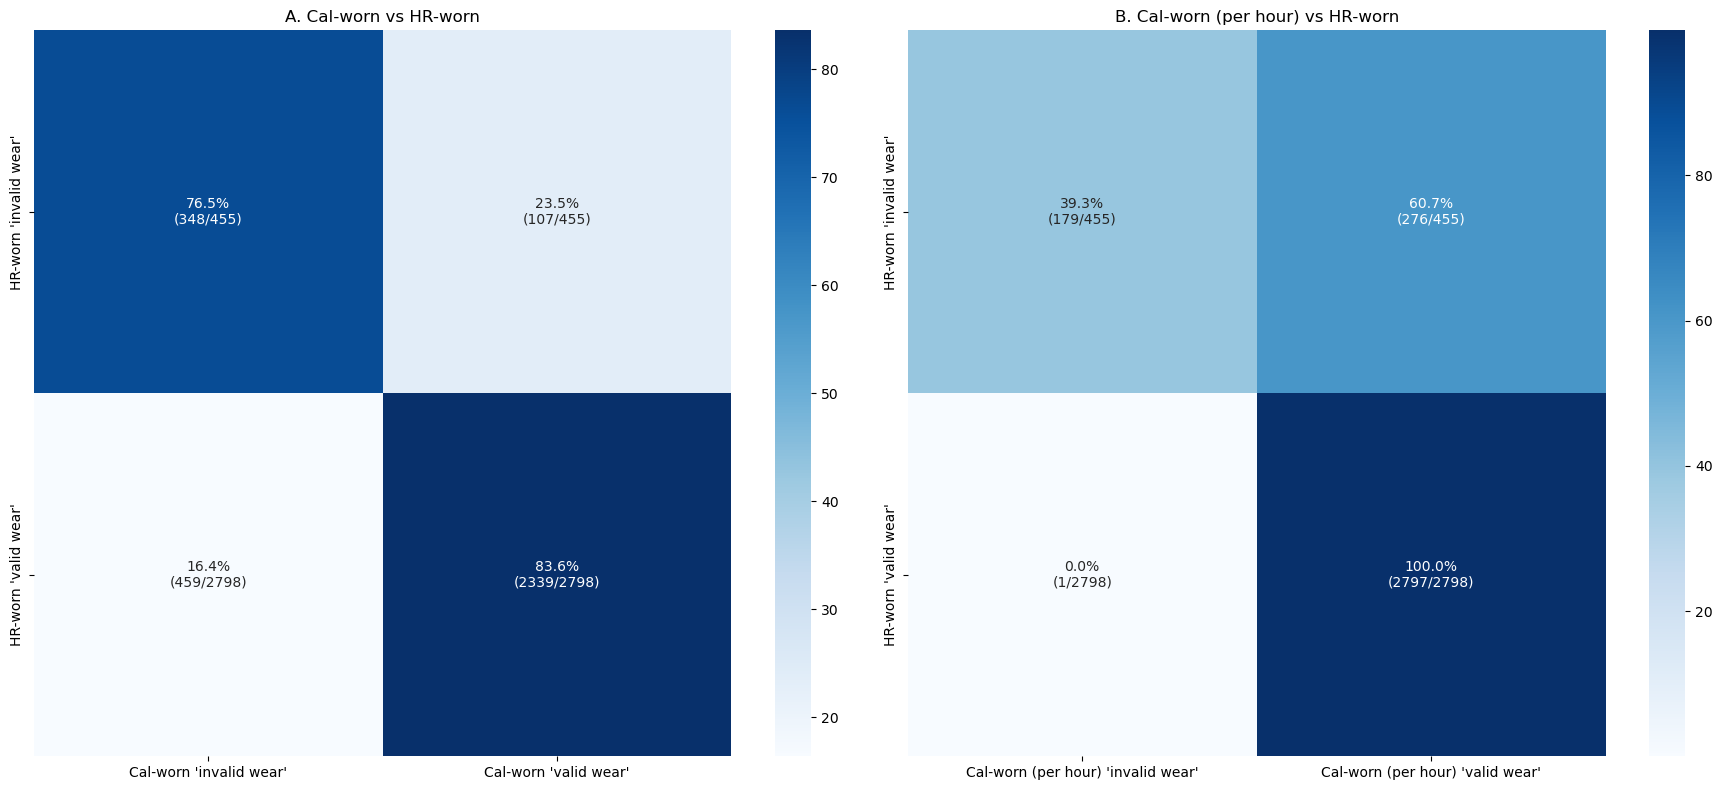

In [11]:
#2- Confusion matrix

# First columns pair
y_true_pair1 = df_final['HR-worn'].astype(int)  # Convert boolean to binary (0 or 1)
y_pred_pair1 = df_final['Cal-worn'].astype(int)  
cm_pair1 = confusion_matrix(y_true_pair1, y_pred_pair1)
# Second columns pair
y_true_pair2 = df_final['HR-worn'].astype(int)  
y_pred_pair2 = df_final['Cal-worn(per-hour)'].astype(int) 
cm_pair2 = confusion_matrix(y_true_pair2, y_pred_pair2)
# Numbers to percentages in cells
cm_pair1_percent = cm_pair1 / cm_pair1.sum(axis=1)[:, np.newaxis] * 100
cm_pair2_percent = cm_pair2 / cm_pair2.sum(axis=1)[:, np.newaxis] * 100
cm_pair1_labels = np.array([f"{value:.1f}%\n({int(count)}/{int(total)})"
                            for value, count, total in zip(cm_pair1_percent.flatten(), cm_pair1.flatten(), cm_pair1.sum(axis=1).repeat(2))]).reshape(2,2)
cm_pair2_labels = np.array([f"{value:.1f}%\n({int(count)}/{int(total)})"
                            for value, count, total in zip(cm_pair2_percent.flatten(), cm_pair2.flatten(), cm_pair2.sum(axis=1).repeat(2))]).reshape(2,2)

# Ploting
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# First matrix
sns.heatmap(cm_pair1_percent, annot=cm_pair1_labels, fmt="", cmap="Blues", xticklabels=["Cal-worn 'invalid wear'", "Cal-worn 'valid wear'"], 
            yticklabels=["HR-worn 'invalid wear'", "HR-worn 'valid wear'"], ax=axes[0])
axes[0].set_title("A. Cal-worn vs HR-worn")

# Second matrix
sns.heatmap(cm_pair2_percent, annot=cm_pair2_labels, fmt="", cmap="Blues", xticklabels=["Cal-worn (per hour) 'invalid wear'", "Cal-worn (per hour) 'valid wear'"], 
            yticklabels=["HR-worn 'invalid wear'", "HR-worn 'valid wear'"], ax=axes[1])
axes[1].set_title("B. Cal-worn (per hour) vs HR-worn")

plt.tight_layout()
plt.show()


### Review 1 - update design matrix
This updated version of the figure includes
- keeping colors consistent with fig 6 (Cal-worn VS HR-worn = blue, Cal-worn (per hour) VS HR-worn = orange)

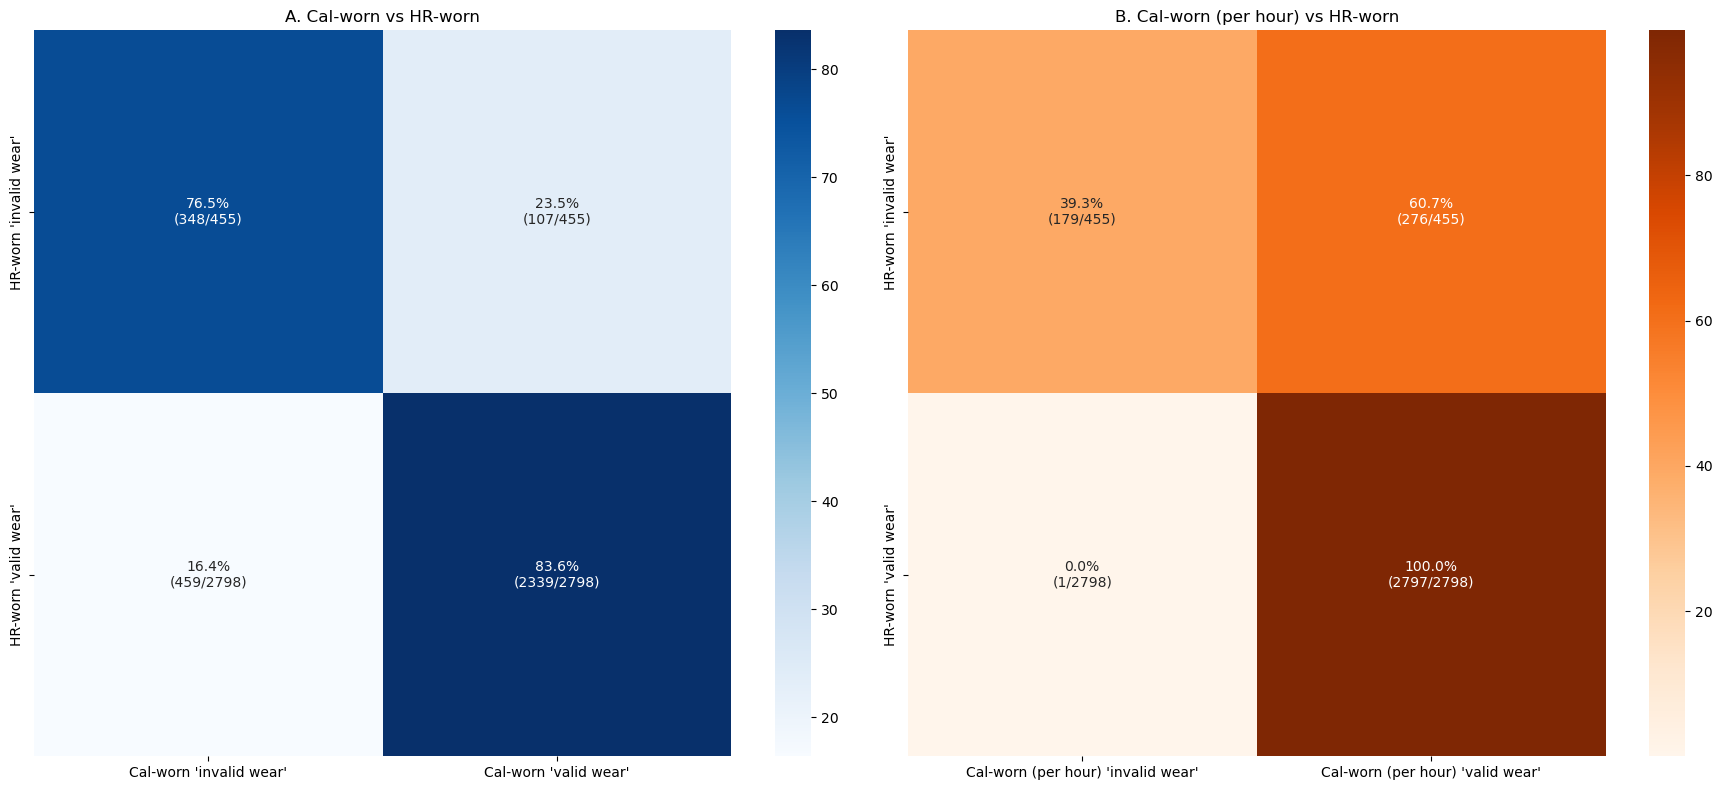

In [41]:
# First columns pair
y_true_pair1 = df_final['HR-worn'].astype(int)  # Convert boolean to binary (0 or 1)
y_pred_pair1 = df_final['Cal-worn'].astype(int)  
cm_pair1 = confusion_matrix(y_true_pair1, y_pred_pair1)

# Second columns pair
y_true_pair2 = df_final['HR-worn'].astype(int)  
y_pred_pair2 = df_final['Cal-worn(per-hour)'].astype(int) 
cm_pair2 = confusion_matrix(y_true_pair2, y_pred_pair2)

# Convert numbers to percentages
cm_pair1_percent = cm_pair1 / cm_pair1.sum(axis=1)[:, np.newaxis] * 100
cm_pair2_percent = cm_pair2 / cm_pair2.sum(axis=1)[:, np.newaxis] * 100

# Labels for heatmaps
cm_pair1_labels = np.array([
    f"{value:.1f}%\n({int(count)}/{int(total)})"
    for value, count, total in zip(cm_pair1_percent.flatten(), cm_pair1.flatten(), cm_pair1.sum(axis=1).repeat(2))
]).reshape(2,2)

cm_pair2_labels = np.array([
    f"{value:.1f}%\n({int(count)}/{int(total)})"
    for value, count, total in zip(cm_pair2_percent.flatten(), cm_pair2.flatten(), cm_pair2.sum(axis=1).repeat(2))
]).reshape(2,2)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# First matrix (Blues)
sns.heatmap(cm_pair1_percent, annot=cm_pair1_labels, fmt="", cmap="Blues", 
            xticklabels=["Cal-worn 'invalid wear'", "Cal-worn 'valid wear'"], 
            yticklabels=["HR-worn 'invalid wear'", "HR-worn 'valid wear'"], 
            ax=axes[0])
axes[0].set_title("A. Cal-worn vs HR-worn")

# Second matrix (Oranges)
sns.heatmap(cm_pair2_percent, annot=cm_pair2_labels, fmt="", cmap="Oranges", 
            xticklabels=["Cal-worn (per hour) 'invalid wear'", "Cal-worn (per hour) 'valid wear'"], 
            yticklabels=["HR-worn 'invalid wear'", "HR-worn 'valid wear'"], 
            ax=axes[1])
axes[1].set_title("B. Cal-worn (per hour) vs HR-worn")

plt.tight_layout()
plt.show()


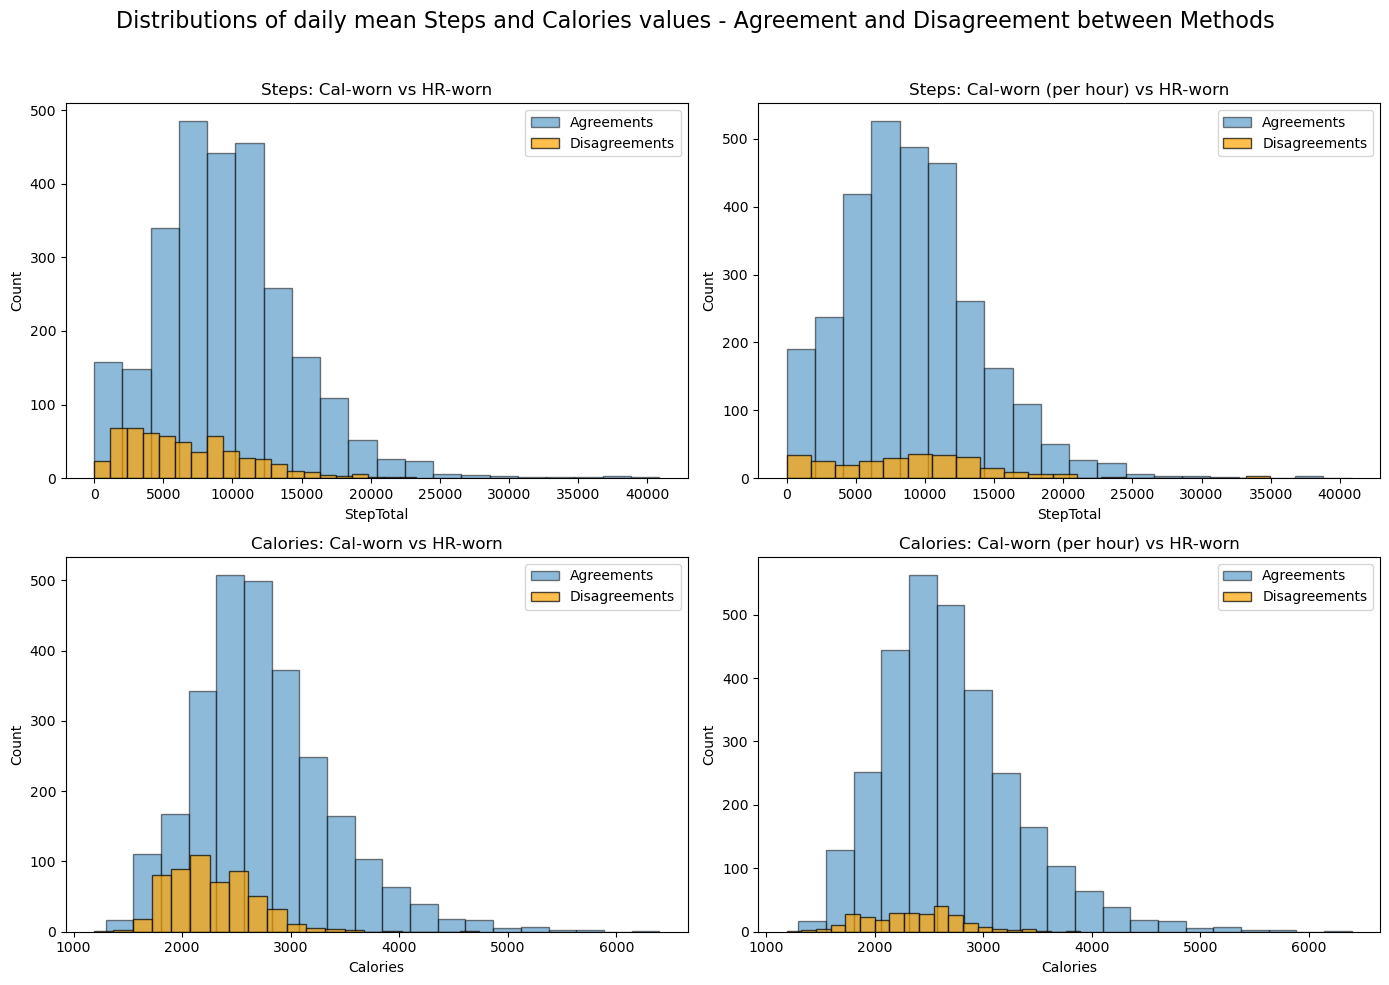

In [12]:
#3- Distribution of disgreement according to the Steps and Calories values

df = df_final.reset_index(drop=True)

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

def plot_histogram_with_disagreements(df, method1_col, methodHR_col, measure_col, ax, title):
    df_disagreement = df[df[method1_col] != df[methodHR_col]]
    df_agreement = df[df[method1_col] == df[methodHR_col]]
    # Calculate statistical values for the measure with disagreements
    q1_dis_val = df_disagreement[measure_col].quantile(0.25)
    median_dis_val = df_disagreement[measure_col].median()
    q3_dis_val = df_disagreement[measure_col].quantile(0.75)
    # Histogram of the measure for agreements 
    ax.hist(df_agreement[measure_col], bins=20, edgecolor='k', alpha=0.5, label='Agreements')
    # Histogram of the measure for disagreements
    ax.hist(df_disagreement[measure_col], bins=20, edgecolor='k', alpha=0.7, label='Disagreements', color='orange')
    # Add lines for quartiles and median for disagreements
    # ax.axvline(q1_dis_val, color='b', linestyle='dashed', linewidth=2, label=f'Dis. Q1: {q1_dis_val}')
    # ax.axvline(median_dis_val, color='r', linestyle='dashed', linewidth=2, label=f'Dis. Q2: {median_dis_val}')
    # ax.axvline(q3_dis_val, color='m', linestyle='dashed', linewidth=2, label=f'Dis. Q3: {q3_dis_val}')
    # Some adjustments
    ax.set_xlabel(measure_col)
    ax.set_ylabel('Count')
    ax.set_title(title)
    ax.legend()
    # ax.grid(True)

plot_histogram_with_disagreements(df, 'Cal-worn', 'HR-worn', 'StepTotal', axs[0, 0], 'Steps: Cal-worn vs HR-worn')
plot_histogram_with_disagreements(df, 'Cal-worn(per-hour)', 'HR-worn', 'StepTotal', axs[0, 1], 'Steps: Cal-worn (per hour) vs HR-worn')
plot_histogram_with_disagreements(df, 'Cal-worn', 'HR-worn', 'Calories', axs[1, 0], 'Calories: Cal-worn vs HR-worn')
plot_histogram_with_disagreements(df, 'Cal-worn(per-hour)', 'HR-worn', 'Calories', axs[1, 1], 'Calories: Cal-worn (per hour) vs HR-worn')

plt.suptitle('Distributions of daily mean Steps and Calories values - Agreement and Disagreement between Methods', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## 2.3- Distribution analysis - day wise

In [13]:
# creating a copy and renaming columns to avoid any mistake due to space or signs
df_anova = df_final[['ID', 'StepTotal', 'Calories', 'Cal-worn', 'Cal-worn(per-hour)', 'HR-worn']].copy()
df_anova.rename(columns={'Cal-worn': 'Cal_worn', 'Cal-worn(per-hour)': 'Cal_worn_per_hour', 'HR-worn': 'HR_worn'}, inplace=True)

# ANOVA on steps
model_steps = ols('StepTotal ~ C(Cal_worn) * C(Cal_worn_per_hour) * C(HR_worn)', data=df_anova).fit()
anova_table_steps = sm.stats.anova_lm(model_steps, typ=2)

# ANOVA on calories
model_calories = ols('Calories ~ C(Cal_worn) * C(Cal_worn_per_hour) * C(HR_worn)', data=df_anova).fit()
anova_table_calories = sm.stats.anova_lm(model_calories, typ=2)

print("ANOVA for Steps :")
print(anova_table_steps)
print('')
print("ANOVA for Calories :")
print(anova_table_calories)


ANOVA for Steps :
                                                   sum_sq      df  \
C(Cal_worn)                                 -6.608704e-05     1.0   
C(Cal_worn_per_hour)                         1.973307e+09     1.0   
C(HR_worn)                                   5.827240e+08     1.0   
C(Cal_worn):C(Cal_worn_per_hour)             9.105137e+09     1.0   
C(Cal_worn):C(HR_worn)                       3.817601e-06     1.0   
C(Cal_worn_per_hour):C(HR_worn)              1.807973e+07     1.0   
C(Cal_worn):C(Cal_worn_per_hour):C(HR_worn)  3.172257e+05     1.0   
Residual                                     7.023410e+10  3247.0   

                                                        F        PR(>F)  
C(Cal_worn)                                 -3.055277e-12  1.000000e+00  
C(Cal_worn_per_hour)                         9.122818e+01  2.434804e-21  
C(HR_worn)                                   2.693998e+01  2.227714e-07  
C(Cal_worn):C(Cal_worn_per_hour)             4.209405e+02  4.646

We found no effect of the method applied (1,2 or HR) on Steps (p = 0.534521) nor Calories (p = 0.662464). This may be due to high differences between subjects. We therefore go with a subject-wise analysis.

## 2.4- Distribution analysis - subject wise

In [14]:
#4- Distribution analysis - mean daily physical activity, subject wise

def mean_steps_by_method(x, method_col):
    return x.loc[x[method_col] == 1, 'StepTotal'].mean()

def mean_calories_by_method(x, method_col):
    return x.loc[x[method_col] == 1, 'Calories'].mean()

grouped = df_final.groupby('ID').apply(lambda x: pd.Series({
    'Steps_Cal-worn': mean_steps_by_method(x, 'Cal-worn'),
    'Steps_Cal-worn(per-hour)': mean_steps_by_method(x, 'Cal-worn(per-hour)'),
    'Steps_HR-worn': mean_steps_by_method(x, 'HR-worn'),
    'Steps_All': x['StepTotal'].mean(),
    'Calories_Cal-worn': mean_calories_by_method(x, 'Cal-worn'),
    'Calories_Cal-worn(per-hour)': mean_calories_by_method(x, 'Cal-worn(per-hour)'),
    'Calories_HR-worn': mean_calories_by_method(x, 'HR-worn'),
    'Calories_All': x['Calories'].mean()
})).reset_index()

num_days_observation = df_final.groupby('ID').size().reset_index(name='numDays')
grouped = grouped.merge(num_days_observation, on='ID', how='left')
grouped


C:\Users\Matthieu\AppData\Local\Temp\ipykernel_3184\1994175388.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df_final.groupby('ID').apply(lambda x: pd.Series({


,ID,Steps_Cal-worn,Steps_Cal-worn(per-hour),Steps_HR-worn,Steps_All,Calories_Cal-worn,Calories_Cal-worn(per-hour),Calories_HR-worn,Calories_All,numDays
0,033,12696.391304,11079.451613,11882.035714,10313.323529,4020.521739,3683.677419,3852.357143,3521.764706,34
1,038,9884.342105,8979.086957,9185.340909,8800.212766,2807.078947,2706.608696,2731.500000,2687.170213,47
2,043,9890.630952,9354.858586,9474.510870,9115.019417,2783.916667,2688.505051,2727.543478,2653.737864,103
3,045,8954.950980,8828.481132,8879.295238,8780.336449,2374.852941,2359.603774,2365.171429,2354.186916,107
4,052,10755.842105,10382.275000,10604.216216,9587.022727,3981.052632,3903.775000,4001.081081,3740.477273,44
...,...,...,...,...,...,...,...,...,...,...
67,C16,6806.736842,6534.047619,6534.047619,6534.047619,2837.315789,2781.476190,2781.476190,2781.476190,21
68,C17,11128.333333,8032.857143,8131.333333,5241.230769,3582.333333,2944.428571,2984.500000,2488.538462,13
69,C18,10063.000000,7612.181818,8661.444444,7134.076923,3183.666667,2832.000000,3012.555556,2728.230769,13
70,C19,5617.400000,4912.178571,4912.178571,4743.793103,2302.900000,2220.357143,2220.357143,2199.586207,29


Mean daily number of steps realised ('Steps') and calories spend ('Calories') for each each participant ('ID') depending on the method applied ('Method1', 'Method2', 'MethodHR', or no method 'All'), as well as number of days considered ('numDays'). 

  
Subject 040 has only 1 day of observation, and so NaN as steps and calories values with different methods. This is because this subject started the experiment with a Fitbit Alta, and changed for an Alta HR late (5 days of observation). All these days contained an issue of synching, wearing etc. We therefore suppress this subject in further analysis.

In [15]:
subjects_to_exclude = ['078', '087', '091', '094']
df_cleaned = grouped[~grouped['ID'].isin(subjects_to_exclude)]


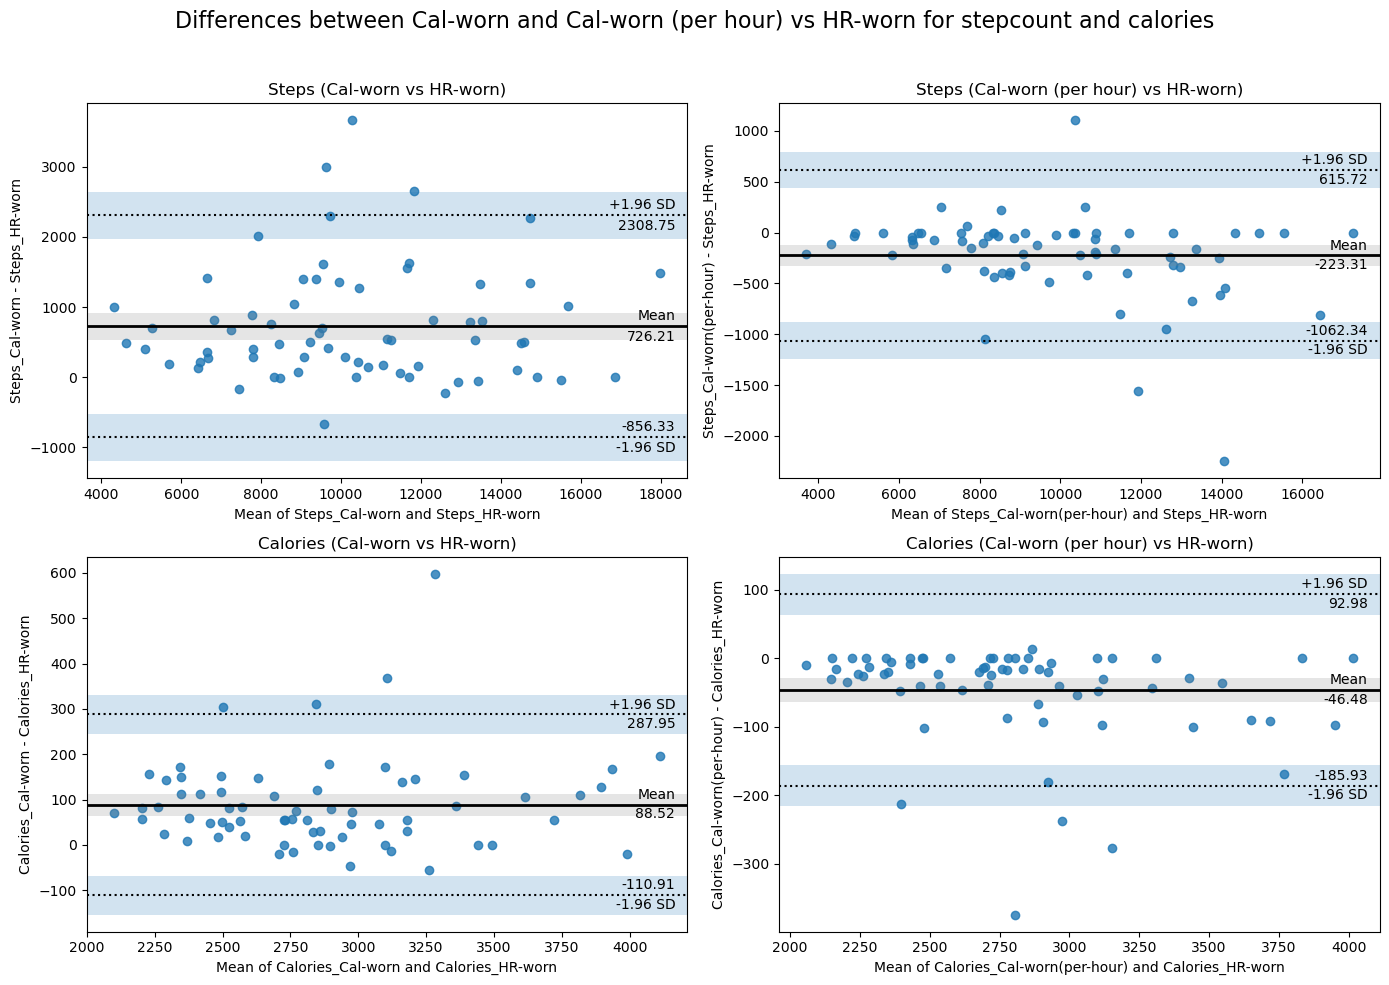

In [16]:
# Set up the figure and axes
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Bland-Altman plot for Steps (Method1 vs MethodHR)
pg.plot_blandaltman(df_cleaned['Steps_Cal-worn'], df_cleaned['Steps_HR-worn'], ax=axs[0, 0])
axs[0, 0].set_title('Steps (Cal-worn vs HR-worn)')

# Bland-Altman plot for Steps (Method2 vs MethodHR)
pg.plot_blandaltman(df_cleaned['Steps_Cal-worn(per-hour)'], df_cleaned['Steps_HR-worn'], ax=axs[0, 1])
axs[0, 1].set_title('Steps (Cal-worn (per hour) vs HR-worn)')

# Bland-Altman plot for Calories (Method1 vs MethodHR)
pg.plot_blandaltman(df_cleaned['Calories_Cal-worn'], df_cleaned['Calories_HR-worn'], ax=axs[1, 0])
axs[1, 0].set_title('Calories (Cal-worn vs HR-worn)')

# Bland-Altman plot for Calories (Method2 vs MethodHR)
pg.plot_blandaltman(df_cleaned['Calories_Cal-worn(per-hour)'], df_cleaned['Calories_HR-worn'], ax=axs[1, 1])
axs[1, 1].set_title('Calories (Cal-worn (per hour) vs HR-worn)')

# General plot settings
plt.suptitle('Differences between Cal-worn and Cal-worn (per hour) vs HR-worn for stepcount and calories', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


This figure is presented in a different maner in the paper manuscript.

### Review 1 - ME, MAE, MAPE, RMSE
(...)

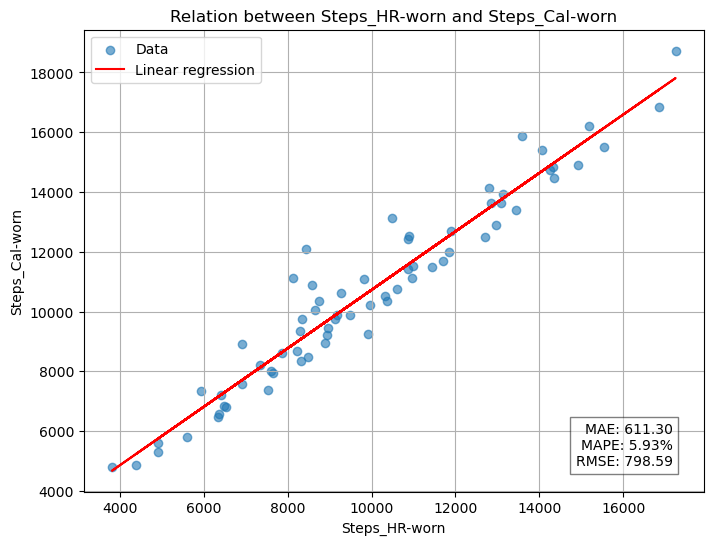

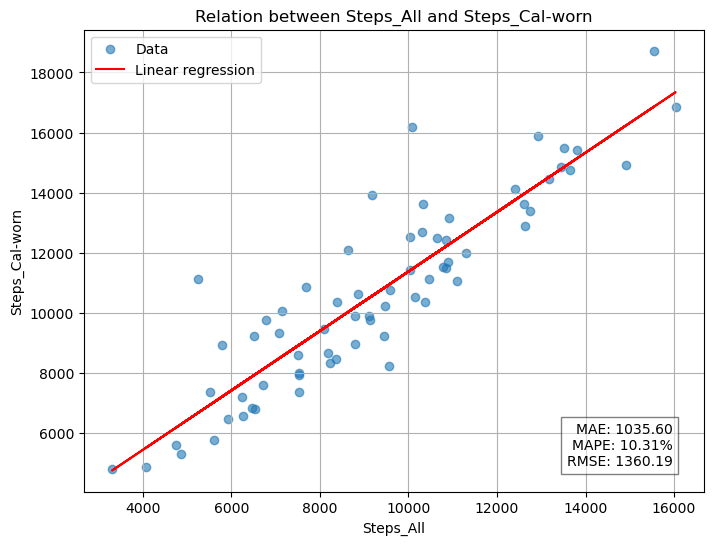

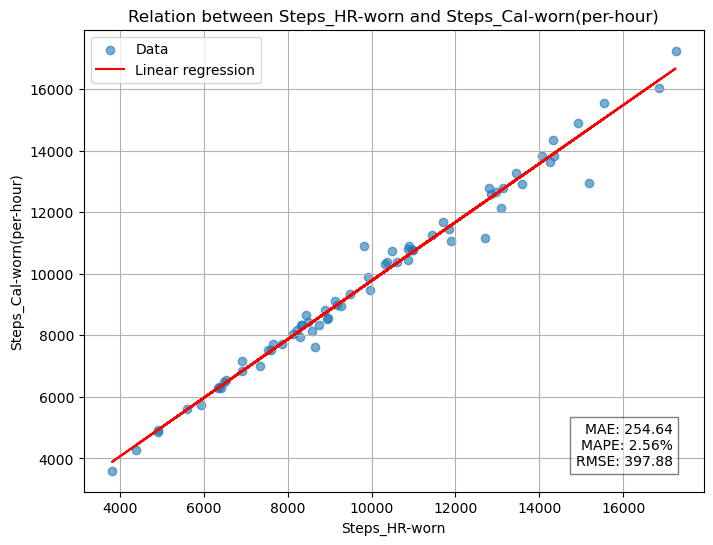

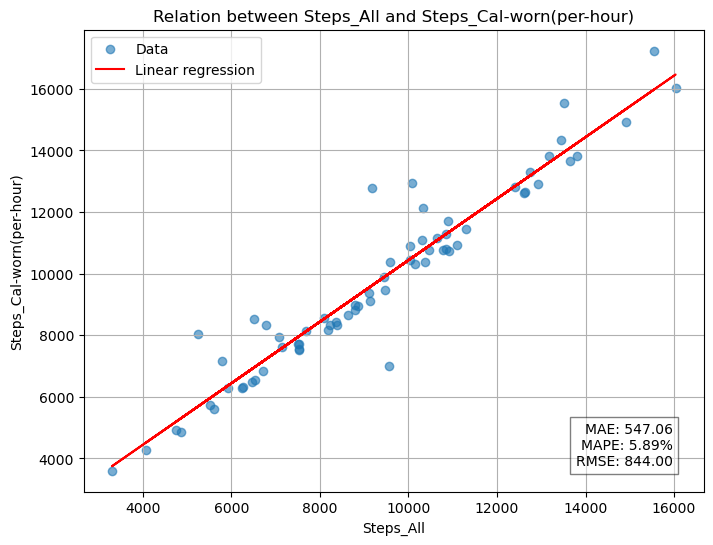

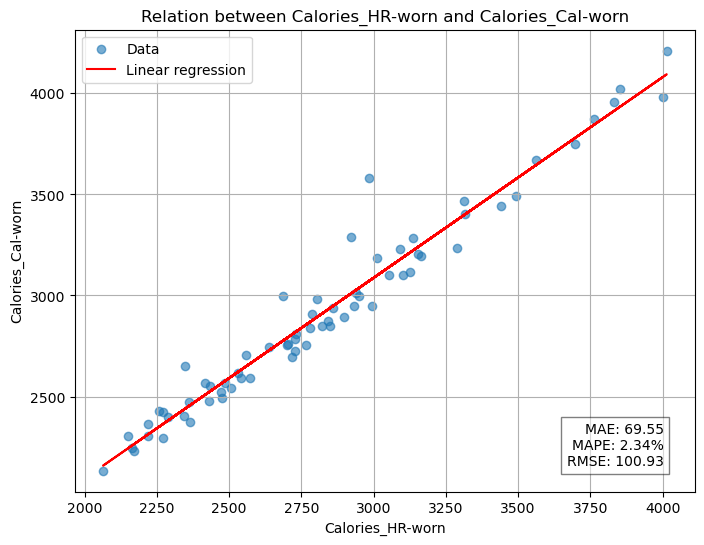

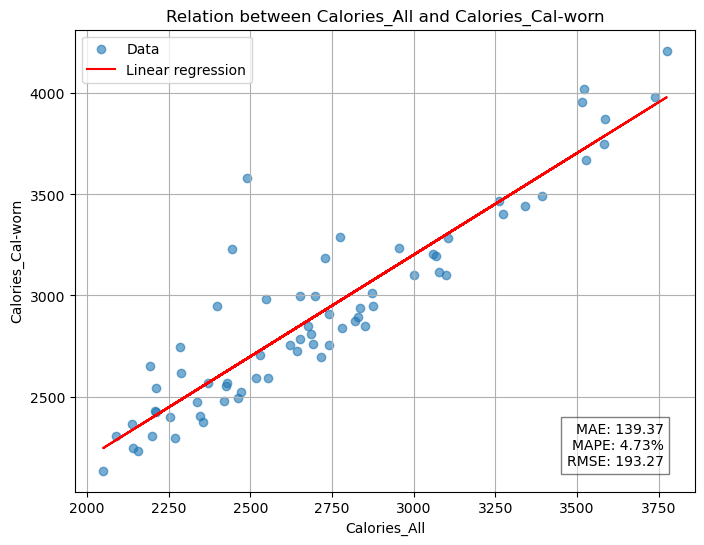

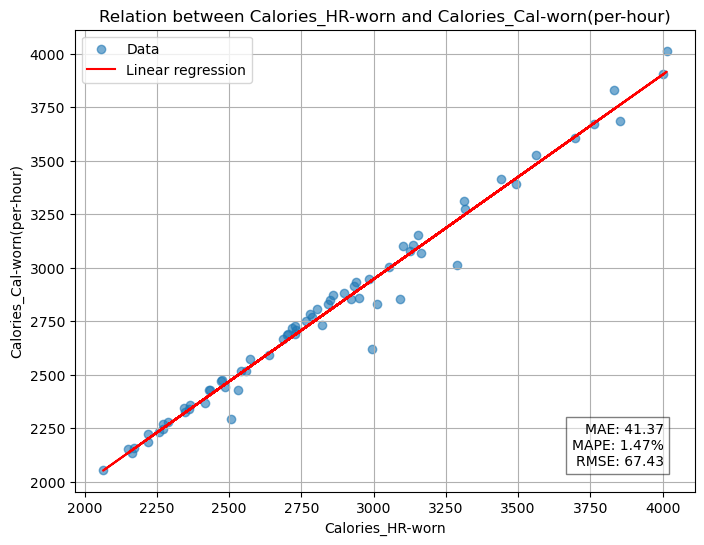

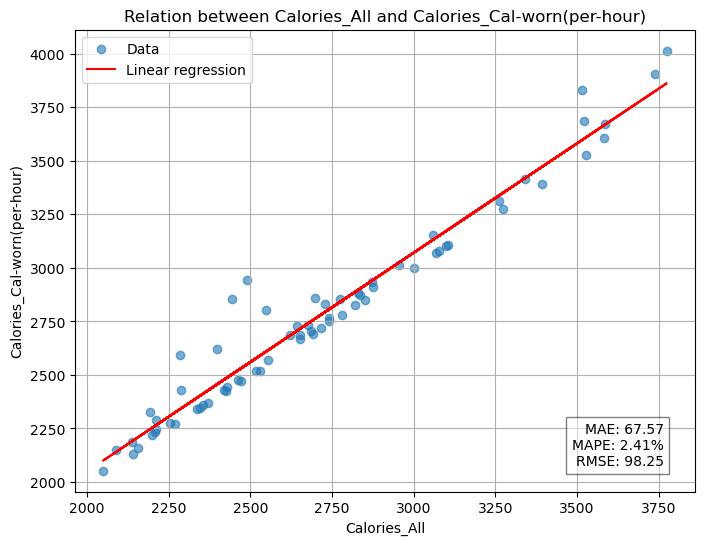

In [74]:
# Function to perform regression and display the plot
def plot_regression_and_metrics(df, x_column, y_column):
    X = df[[x_column]].values
    y = df[y_column].values

    # Linear regression
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    # Calculating errors
    ME = np.mean(y_pred - y)
    MAE = mean_absolute_error(y, y_pred)
    MAPE = np.mean(np.abs((y - y_pred) / y)) * 100  # as a percentage
    RMSE = np.sqrt(mean_squared_error(y, y_pred))

    # Creating the scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(X, y, label="Data", alpha=0.6)
    plt.plot(X, y_pred, color='red', label="Linear regression")
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.title(f"Relation between {x_column} and {y_column}")
    plt.legend()
    plt.grid(True)

    # Displaying metrics at the bottom right
    metrics_text = f"MAE: {MAE:.2f}\nMAPE: {MAPE:.2f}%\nRMSE: {RMSE:.2f}"
    plt.text(0.95, 0.05, metrics_text, transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='bottom', horizontalalignment='right',
             bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))

    plt.show()

# Calling the function for each pair of columns
plot_regression_and_metrics(df_cleaned, 'Steps_HR-worn', 'Steps_Cal-worn')
plot_regression_and_metrics(df_cleaned, 'Steps_All', 'Steps_Cal-worn')
plot_regression_and_metrics(df_cleaned, 'Steps_HR-worn', 'Steps_Cal-worn(per-hour)')
plot_regression_and_metrics(df_cleaned, 'Steps_All', 'Steps_Cal-worn(per-hour)')

plot_regression_and_metrics(df_cleaned, 'Calories_HR-worn', 'Calories_Cal-worn')
plot_regression_and_metrics(df_cleaned, 'Calories_All', 'Calories_Cal-worn')
plot_regression_and_metrics(df_cleaned, 'Calories_HR-worn', 'Calories_Cal-worn(per-hour)')
plot_regression_and_metrics(df_cleaned, 'Calories_All', 'Calories_Cal-worn(per-hour)')


In [17]:
# Test for distribution normality
columns_to_test = ['Steps_Cal-worn', 'Steps_Cal-worn(per-hour)', 'Steps_HR-worn', 'Steps_All', 
                   'Calories_Cal-worn', 'Calories_Cal-worn(per-hour)','Calories_HR-worn', 'Calories_All']

shapiro_results = {}
for col in columns_to_test:
    stat, p_value = shapiro(df_cleaned[col].dropna())
    shapiro_results[col] = (stat, p_value)

for col, (stat, p_value) in shapiro_results.items():
    print(f'Column: {col}, Statistic: {stat:.4f}, p-value: {p_value:.4f}')
    if p_value > 0.05:
        print(f'   Normality distribution for data in {col} (p > 0.05).')
    else:
        print(f'   NON-normality distribution for data in {col}  (p ≤ 0.05).')
    print('---')


Column: Steps_Cal-worn, Statistic: 0.9882, p-value: 0.7719
   Normality distribution for data in Steps_Cal-worn (p > 0.05).
---
Column: Steps_Cal-worn(per-hour), Statistic: 0.9862, p-value: 0.6568
   Normality distribution for data in Steps_Cal-worn(per-hour) (p > 0.05).
---
Column: Steps_HR-worn, Statistic: 0.9818, p-value: 0.4207
   Normality distribution for data in Steps_HR-worn (p > 0.05).
---
Column: Steps_All, Statistic: 0.9866, p-value: 0.6783
   Normality distribution for data in Steps_All (p > 0.05).
---
Column: Calories_Cal-worn, Statistic: 0.9473, p-value: 0.0061
   NON-normality distribution for data in Calories_Cal-worn  (p ≤ 0.05).
---
Column: Calories_Cal-worn(per-hour), Statistic: 0.9451, p-value: 0.0047
   NON-normality distribution for data in Calories_Cal-worn(per-hour)  (p ≤ 0.05).
---
Column: Calories_HR-worn, Statistic: 0.9492, p-value: 0.0077
   NON-normality distribution for data in Calories_HR-worn  (p ≤ 0.05).
---
Column: Calories_All, Statistic: 0.9407, p-va

As the distribution for Calories value are non normal, we apply a non-parametric test for differences in Steps and Calories distribution between methods 1, 2 and HR.

In [18]:
# Friedman test - global effect
def test_method_effect_global(df, variable):
    print(f"Effect of methods on {variable}:")
    columns = [f"{variable}_Cal-worn", f"{variable}_Cal-worn(per-hour)", f"{variable}_HR-worn", f"{variable}_All"]
    try:
        df_filtered = df.dropna(subset=columns)
        stat, p_value = friedmanchisquare(df_filtered[columns[0]], df_filtered[columns[1]], df_filtered[columns[2]])
        print(f"Friedman Test for {variable}: Statistic={stat:.2f}, p-value={p_value:.4f}")
        if p_value < 0.05:
            print("Reject null hypothesis: There is a significant difference between methods.")
        else:
            print("Fail to reject null hypothesis: No significant difference between methods.")
        print()
    except KeyError as e:
        print(f"Error: One or more columns {e} not found in DataFrame.")

print('->Friedman global effect of Method (Cal-worn x Cal-worn (per hour) x HR-worn) on Steps and Calories')
test_method_effect_global(df_cleaned, 'Steps')
test_method_effect_global(df_cleaned, 'Calories')
print('===============================')

# Conover post hoc test
def test_post_hoc_conover(df, variable):
    columns = [f"{variable}_Cal-worn", f"{variable}_Cal-worn(per-hour)", f"{variable}_HR-worn", f"{variable}_All"]  
    df_filtered = df.dropna(subset=columns)
    # rank calculation
    ranks = df_filtered[columns].apply(rankdata, axis=1) #rank calculation
    mean_ranks = ranks.mean()
    print(f"Mean Ranks for {variable}:")
    print(mean_ranks)
    print()
    # pairs comparison
    pairs = list(itertools.combinations(columns, 2))
    for pair in pairs:
        print(f"Comparing {pair[0]} vs {pair[1]}:")
        stat, p_value = ranksums(df_filtered[pair[0]], df_filtered[pair[1]])
        print(f"Ranksums Test (Conover) for {pair[0]} vs {pair[1]}: Statistic={stat:.4f}, p-value={p_value:.4f}")
        if p_value < 0.05:
            print("Reject null hypothesis: There is a significant difference between methods.")
        else:
            print("Fail to reject null hypothesis: No significant difference between methods.")
        print()

print('->Conover post-hoc test for pair-wise methods comparison')
test_post_hoc_conover(df_cleaned, 'Steps')
print('-------------------------')
test_post_hoc_conover(df_cleaned, 'Calories')


->Friedman global effect of Method (Cal-worn x Cal-worn (per hour) x HR-worn) on Steps and Calories
Effect of methods on Steps:
Friedman Test for Steps: Statistic=89.64, p-value=0.0000
Reject null hypothesis: There is a significant difference between methods.

Effect of methods on Calories:
Friedman Test for Calories: Statistic=101.54, p-value=0.0000
Reject null hypothesis: There is a significant difference between methods.

->Conover post-hoc test for pair-wise methods comparison
Mean Ranks for Steps:
[3.72794118 2.05882353 2.82352941 1.38970588]

Comparing Steps_Cal-worn vs Steps_Cal-worn(per-hour):
Ranksums Test (Conover) for Steps_Cal-worn vs Steps_Cal-worn(per-hour): Statistic=1.6865, p-value=0.0917
Fail to reject null hypothesis: No significant difference between methods.

Comparing Steps_Cal-worn vs Steps_HR-worn:
Ranksums Test (Conover) for Steps_Cal-worn vs Steps_HR-worn: Statistic=1.3449, p-value=0.1787
Fail to reject null hypothesis: No significant difference between methods

With a subject-wise approach, we found that the method applied (1, 2 or HR) have a global impact on the daily mean step count and calories spend values. Post-hoc tests showed that the pair-wise difference is statistically significant between methods 1 and 2 for steps. The rest of difference is due to global distribution differences. We represent this with a boxplot figure.

C:\Users\Matthieu\AppData\Local\Temp\ipykernel_3184\642691662.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Method', y='Value_Steps', data=df_steps, ax=axes[0], palette=palette_steps)
C:\Users\Matthieu\AppData\Local\Temp\ipykernel_3184\642691662.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels([' ', ' ', ' ',' '])
C:\Users\Matthieu\AppData\Local\Temp\ipykernel_3184\642691662.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Method', y='Value_Calories', data=df_calories, ax=axes[1], palette=palette_calories)
C:\Users\Matthieu\AppData\Local\Temp\ipykernel_3184\64269

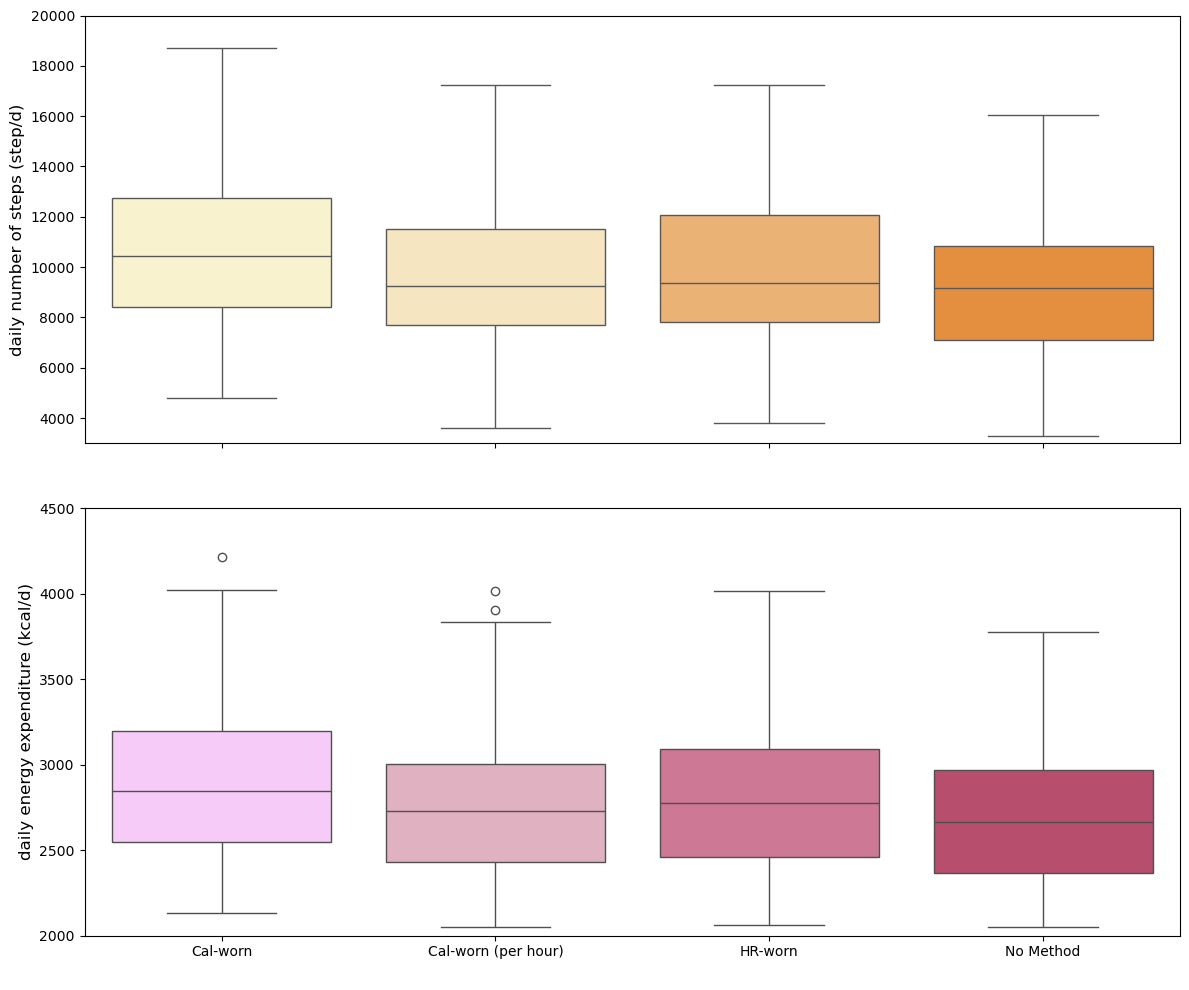

N participants=68
N mean number of days merged = 45.2


In [19]:
# Graphical illustration
df_steps = pd.melt(df_cleaned, id_vars='ID', value_vars=['Steps_Cal-worn', 'Steps_Cal-worn(per-hour)', 'Steps_HR-worn','Steps_All'], var_name='Method', value_name='Value_Steps')
df_calories = pd.melt(df_cleaned, id_vars='ID', value_vars=['Calories_Cal-worn', 'Calories_Cal-worn(per-hour)', 'Calories_HR-worn', 'Calories_All'], var_name='Method', value_name='Value_Calories')

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

palette_steps = sns.color_palette(['#fff8c7', '#ffe8b8', '#ffb361', '#ff8e24'])  
palette_calories = sns.color_palette(['#fec4ff', '#E8AABE', '#DB6A8F', '#CA3C66'])  

#Steps
sns.boxplot(x='Method', y='Value_Steps', data=df_steps, ax=axes[0], palette=palette_steps)
#axes[0].set_title('Mean daily physical activity parameters distribution comparison between 3 methods and original data', fontsize=14, weight='bold')
axes[0].set_xlabel(' ', fontsize=12)
#axes[0].set_ylabel('daily step-count per participants', fontsize=12)
axes[0].set_ylabel('daily number of steps (step/d)', fontsize=12)
axes[0].set_ylim(3000, 20000)
axes[0].set_xticklabels([' ', ' ', ' ',' '])


#Calories
sns.boxplot(x='Method', y='Value_Calories', data=df_calories, ax=axes[1], palette=palette_calories)
axes[1].set_xlabel(' ', fontsize=12)
#axes[1].set_ylabel('daily calories per participants', fontsize=12)
axes[1].set_ylabel('daily energy expenditure (kcal/d)', fontsize=12)
axes[1].set_ylim(2000, 4500)
axes[1].set_xticklabels(['Cal-worn', 'Cal-worn (per hour)', 'HR-worn', "No Method"])


plt.tight_layout()
#plt.savefig("figure 4.png", dpi='figure')
plt.show()


print(f'N participants={len(df_cleaned)}')
mean_num_days = grouped['numDays'].mean()
print(f'N mean number of days merged = {mean_num_days.round(1)}')


### Review 1 - update boxplot
This updated version of the figure includes
- keeping position consistent with fig 6 (EE -> Steps, No Method -> HR -> Cal (h) -> Cal)

C:\Users\Matthieu\AppData\Local\Temp\ipykernel_3184\260584244.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Method', y='Value_Calories', data=df_calories, ax=axes[0], palette=palette_calories)
C:\Users\Matthieu\AppData\Local\Temp\ipykernel_3184\260584244.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels([' ', ' ', ' ', ' '])
C:\Users\Matthieu\AppData\Local\Temp\ipykernel_3184\260584244.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Method', y='Value_Steps', data=df_steps, ax=axes[1], palette=palette_steps)
C:\Users\Matthieu\AppData\Local\Temp\ipykernel_3184\2605

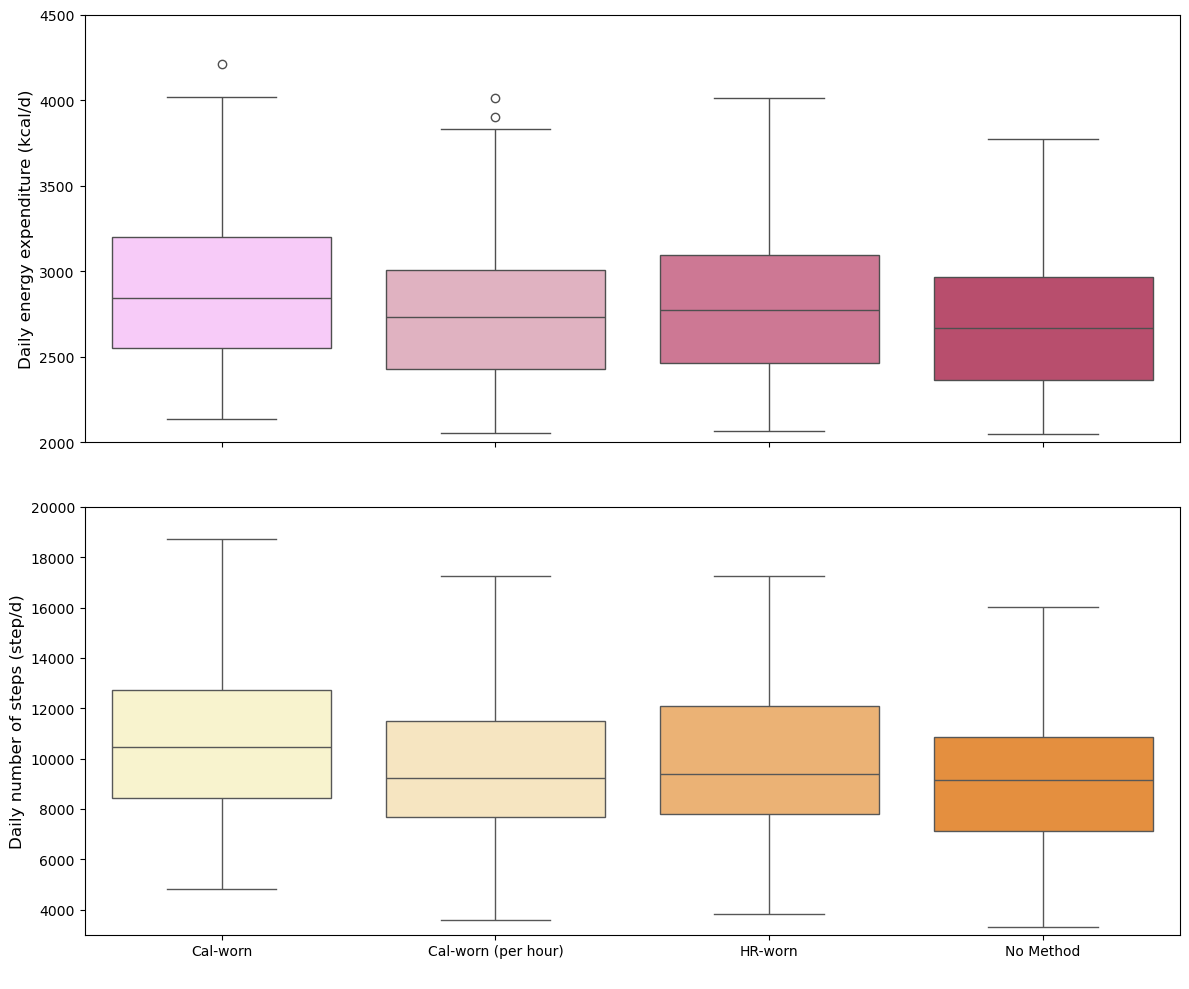

N participants = 68
N mean number of days merged = 45.2


In [40]:
# Reshape data for visualization
df_steps = pd.melt(df_cleaned, id_vars='ID', value_vars=['Steps_Cal-worn', 'Steps_Cal-worn(per-hour)', 'Steps_HR-worn', 'Steps_All'], var_name='Method', value_name='Value_Steps')
df_calories = pd.melt(df_cleaned, id_vars='ID', value_vars=['Calories_Cal-worn', 'Calories_Cal-worn(per-hour)', 'Calories_HR-worn', 'Calories_All'], var_name='Method', value_name='Value_Calories')

# Create figure with 2 rows, 1 column
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Define color palettes
palette_steps = sns.color_palette(['#fff8c7', '#ffe8b8', '#ffb361', '#ff8e24'])  
palette_calories = sns.color_palette(['#fec4ff', '#E8AABE', '#DB6A8F', '#CA3C66'])  

# 1. Calories (now first)
sns.boxplot(x='Method', y='Value_Calories', data=df_calories, ax=axes[0], palette=palette_calories)
axes[0].set_xlabel(' ', fontsize=12)
axes[0].set_ylabel('Daily energy expenditure (kcal/d)', fontsize=12)
axes[0].set_ylim(2000, 4500)
axes[0].set_xticklabels([' ', ' ', ' ', ' '])

# 2. Steps (now second)
sns.boxplot(x='Method', y='Value_Steps', data=df_steps, ax=axes[1], palette=palette_steps)
axes[1].set_xlabel(' ', fontsize=12)
axes[1].set_ylabel('Daily number of steps (step/d)', fontsize=12)
axes[1].set_ylim(3000, 20000)
axes[1].set_xticklabels(['Cal-worn', 'Cal-worn (per hour)', 'HR-worn', "No Method"])


# Adjust layout
plt.tight_layout()
plt.show()

# Print participant information
print(f'N participants = {len(df_cleaned)}')
mean_num_days = grouped['numDays'].mean()
print(f'N mean number of days merged = {mean_num_days.round(1)}')


# 3 - Illustration with one participant
Here, we illustrate the impact of our different methods (1, 2 and HR) on the number of days retained and Steps reccorded in one participant (ID = 056).

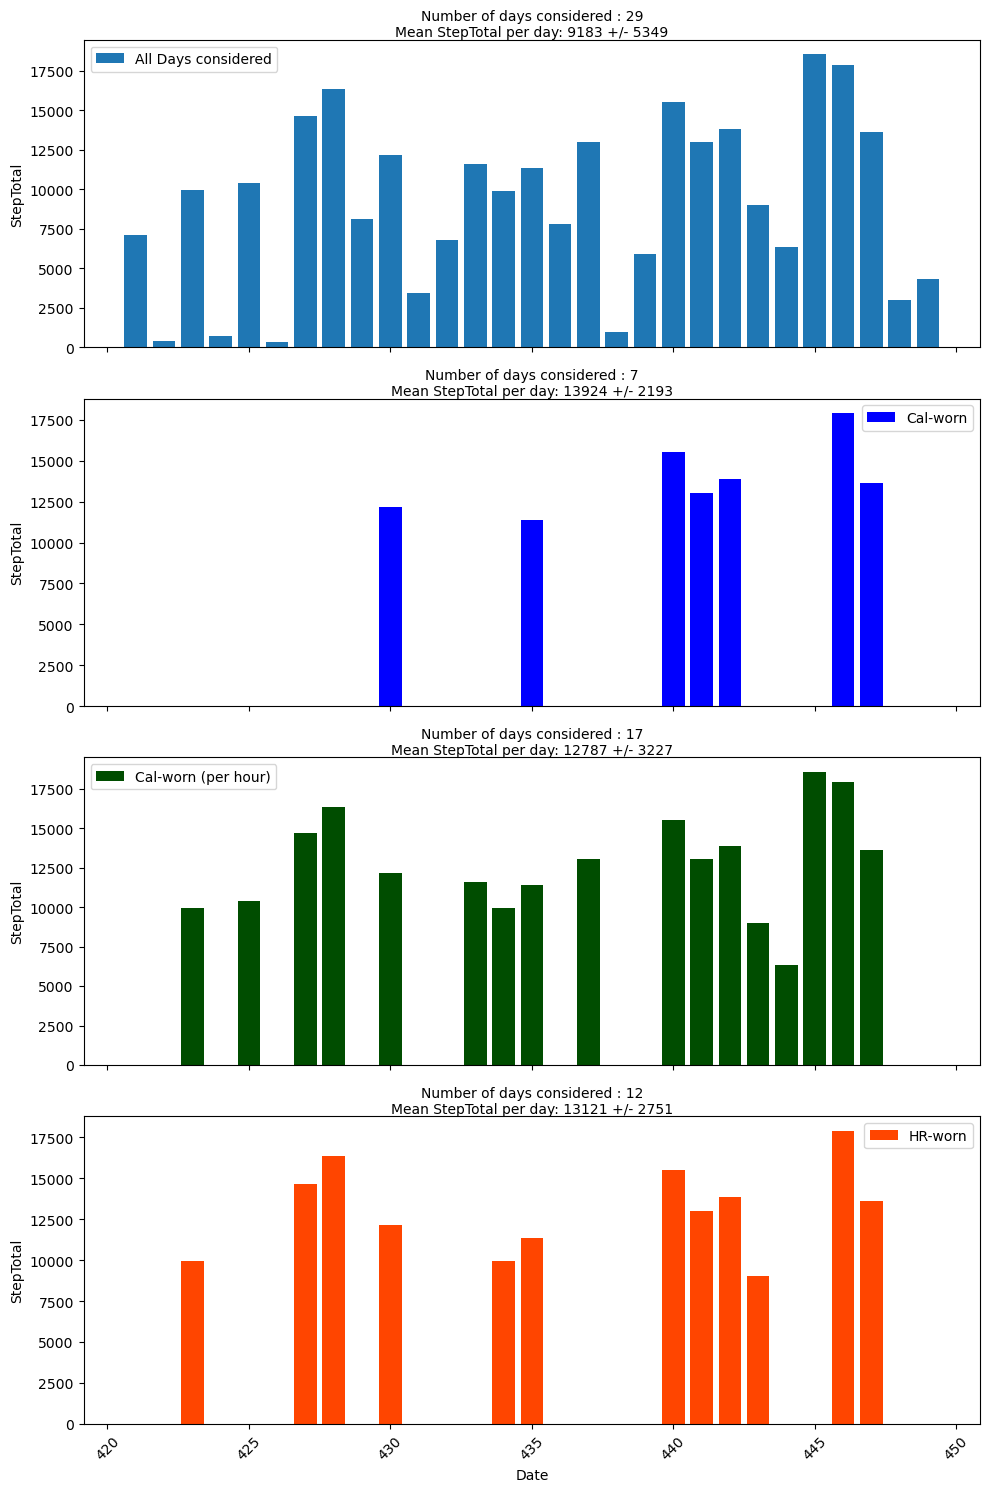

In [20]:
subset_df = df[df['ID'] == '056']

all_days = subset_df
conditionOneStep = subset_df['Stepped'] == True
#conditionOneCalorie= subset_df['oneCalorie'] == True
# conditionNoDiff = subset_df['dataLostSynch'] == False
# considered = subset_df[conditionOneStep & conditionOneCalorie & conditionNoDiff].copy()
considered = subset_df[conditionOneStep].copy()


methodHR = considered[considered['HR-worn'] == True][['StepTotal']].copy()
method1 = considered[considered['Cal-worn'] == True][['StepTotal']].copy()
method2 = considered[considered['Cal-worn(per-hour)'] == True][['StepTotal']].copy()

fig, axs = plt.subplots(4, 1, figsize=(10, 15), sharex=True)

# All days considered
mean_all_days = all_days['StepTotal'].mean()if not all_days['StepTotal'].isnull().all() else 0
std_all_days = all_days['StepTotal'].std()if not all_days['StepTotal'].isnull().all() else 0
axs[0].bar(all_days.index, all_days['StepTotal'], label='All Days considered')
axs[0].legend()
axs[0].set_ylabel('StepTotal')
axs[0].annotate(f"Number of days considered : {len(all_days)}\nMean StepTotal per day: {round(mean_all_days)} +/- {round(std_all_days)}",
                xy=(0.5, 1.05), xycoords='axes fraction', ha='center', va='center')

# Method1
mean_method1 = method1['StepTotal'].mean()
std_method1 = method1['StepTotal'].std()
axs[1].bar(method1.index, method1['StepTotal'], label='Cal-worn', color='#0000FF')
axs[1].legend()
axs[1].set_ylabel('StepTotal')
axs[1].annotate(f"Number of days considered : {len(method1)}\nMean StepTotal per day: {round(mean_method1)} +/- {round(std_method1)}",
                xy=(0.5, 1.05), xycoords='axes fraction', ha='center', va='center')

# Method2
mean_method2 = method2['StepTotal'].mean()
std_method2 = method2['StepTotal'].std()
axs[2].bar(method2.index, method2['StepTotal'], label='Cal-worn (per hour)', color='#004d00')
axs[2].legend()
axs[2].set_ylabel('StepTotal')
axs[2].annotate(f"Number of days considered : {len(method2)}\nMean StepTotal per day: {round(mean_method2)} +/- {round(std_method2)}",
                xy=(0.5, 1.05), xycoords='axes fraction', ha='center', va='center')

# MethodHR
mean_methodHR = methodHR['StepTotal'].mean()
std_methodHR = methodHR['StepTotal'].std()
axs[3].bar(methodHR.index, methodHR['StepTotal'], label='HR-worn', color='#FF4500')
axs[3].legend()
axs[3].set_xlabel('Date')
axs[3].set_ylabel('StepTotal')
axs[3].annotate(f"Number of days considered : {len(methodHR)}\nMean StepTotal per day: {round(mean_methodHR)} +/- {round(std_methodHR)}",
                xy=(0.5, 1.05), xycoords='axes fraction', ha='center', va='center')

for ax in axs.flat:
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


### Review 1 - update histogram
This updated version of the figure includes
- a pannel with EE in addition to Steps
- changing the x-ticks from "Date" to "Days"
- keeping names consistent with fig. 4 ("All days considered" -> "No Method")
- keeping colors consistent with fig. 4 (and so adding edge color)

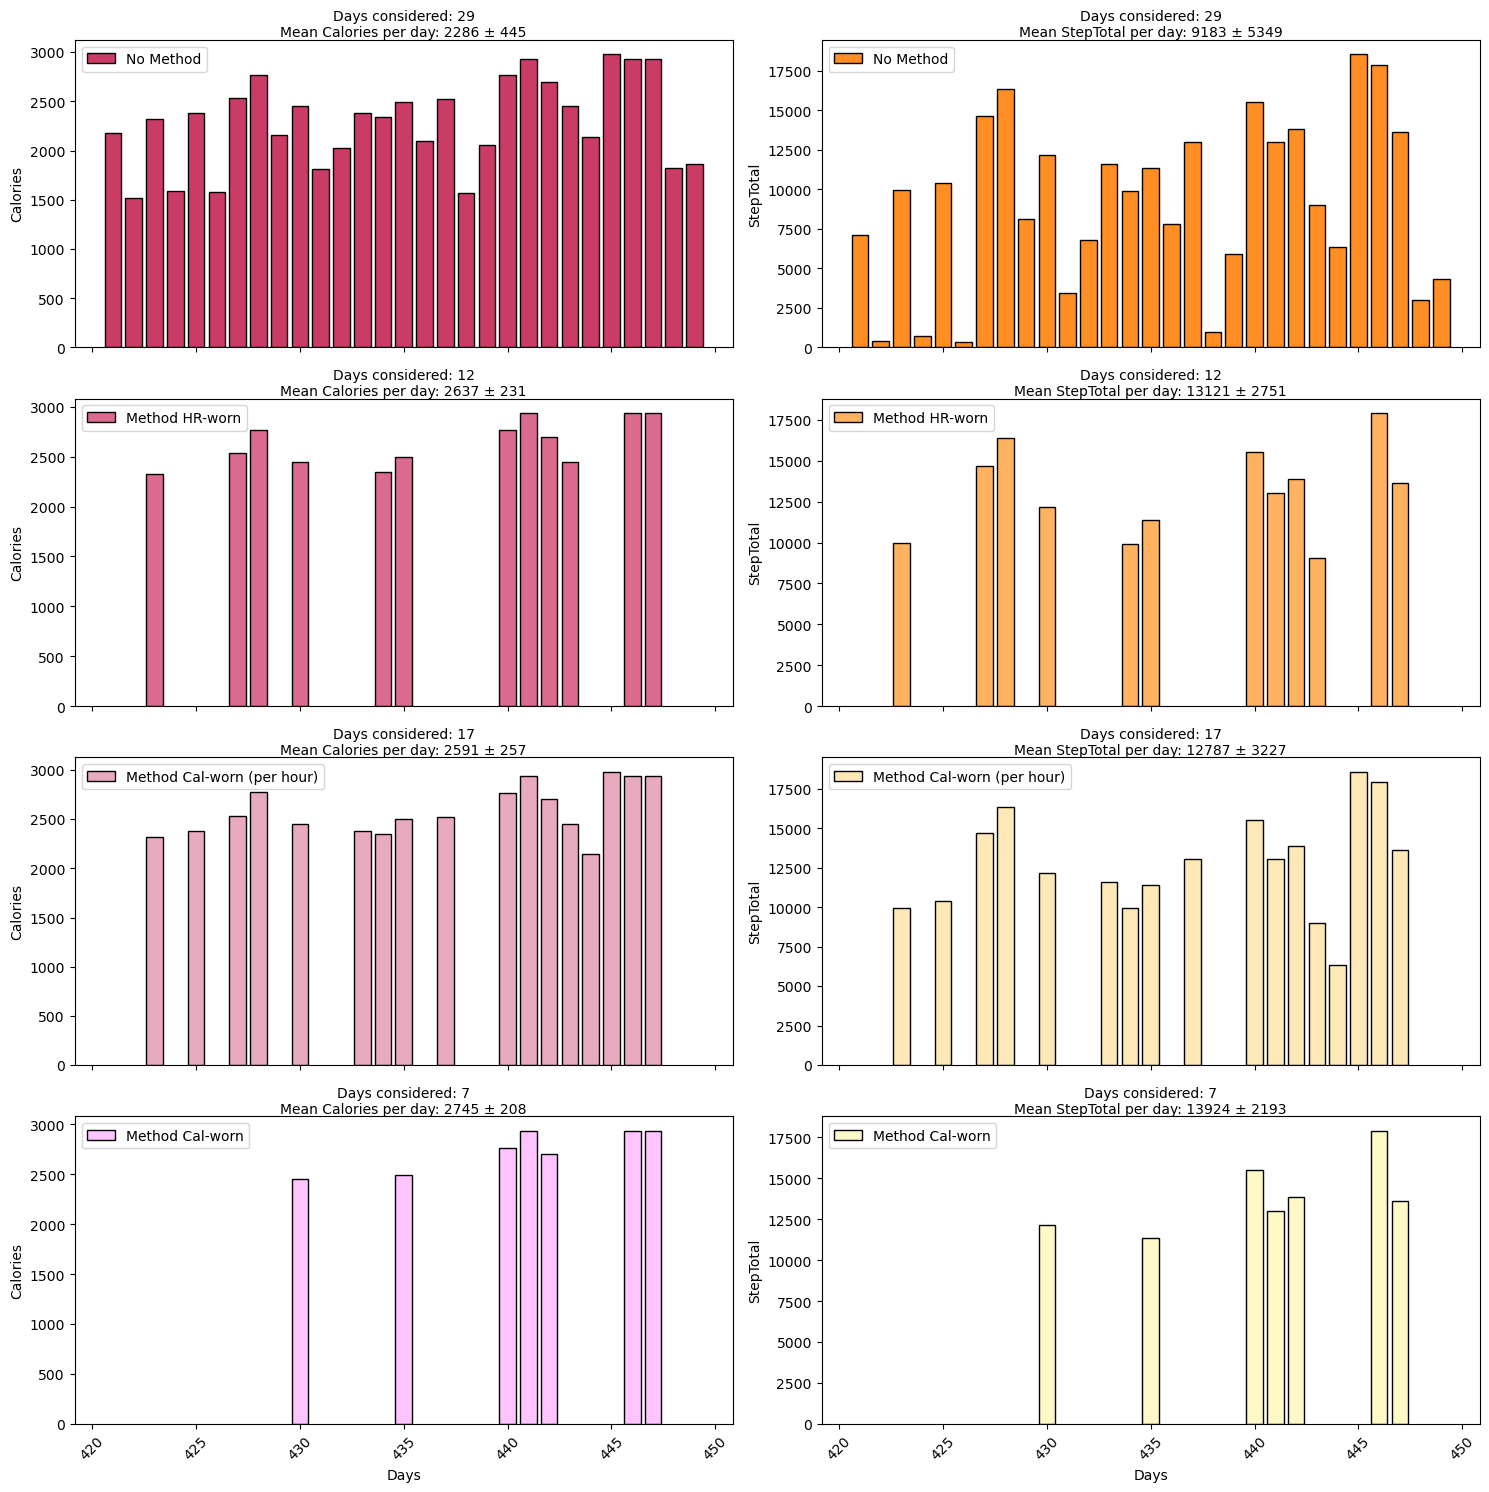

In [ ]:
# Define color palettes
palette_steps = ['#ff8e24', '#ffb361', '#ffe8b8', '#fff8c7']  
palette_calories = ['#CA3C66', '#DB6A8F', '#E8AABE', '#fec4ff']  

# Filter data for the specific ID
subset_df = df[df['ID'] == '056']
all_days = subset_df
conditionOneStep = subset_df['Stepped'] == True
considered = subset_df[conditionOneStep].copy()

# Extract data for analysis
methodHR = considered[considered['HR-worn'] == True][['StepTotal', 'Calories']].copy()
method1 = considered[considered['Cal-worn'] == True][['StepTotal', 'Calories']].copy()
method2 = considered[considered['Cal-worn(per-hour)'] == True][['StepTotal', 'Calories']].copy()

# Create a 4-row x 2-column figure
fig, axs = plt.subplots(4, 2, figsize=(15, 15), sharex=True)

# Function to plot bar charts with custom colors
def plot_data(ax, data, column, label, color):
    mean_val = data[column].mean() if not data[column].isnull().all() else 0
    std_val = data[column].std() if not data[column].isnull().all() else 0
    ax.bar(data.index, data[column], label=label, color=color, edgecolor="black")
    ax.legend()
    ax.set_ylabel(f"{column}")
    ax.annotate(f"Days considered: {len(data)}\nMean {column} per day: {round(mean_val)} ± {round(std_val)}",
                xy=(0.5, 1.05), xycoords='axes fraction', ha='center', va='center')

# Plot Calories (left column) with `palette_calories`
plot_data(axs[0, 0], all_days, 'Calories', 'No Method', palette_calories[0])
plot_data(axs[1, 0], methodHR, 'Calories', 'Method HR-worn', palette_calories[1])
plot_data(axs[2, 0], method2, 'Calories', 'Method Cal-worn (per hour)', palette_calories[2])
plot_data(axs[3, 0], method1, 'Calories', 'Method Cal-worn', palette_calories[3])

# Plot StepTotal (right column) with `palette_steps`
plot_data(axs[0, 1], all_days, 'StepTotal', 'No Method', palette_steps[0])
plot_data(axs[1, 1], methodHR, 'StepTotal', 'Method HR-worn', palette_steps[1])
plot_data(axs[2, 1], method2, 'StepTotal', 'Method Cal-worn (per hour)', palette_steps[2])
plot_data(axs[3, 1], method1, 'StepTotal', 'Method Cal-worn', palette_steps[3])

# Adjustments
for ax in axs.flat:
    ax.tick_params(axis='x', rotation=45)

axs[3, 0].set_xlabel('Days')
axs[3, 1].set_xlabel('Days')

plt.tight_layout()
plt.show()


### Review 1 - use of EE instead of Steps
Illustration of the difference over a day between the use of EE or Steps.

C:\Users\Matthieu\AppData\Local\Temp\ipykernel_3184\3565732792.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ActivityMinute'] = pd.to_datetime(df['ActivityMinute'])
C:\Users\Matthieu\AppData\Local\Temp\ipykernel_3184\3565732792.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ActivityMinute'] = pd.to_datetime(df['ActivityMinute'])


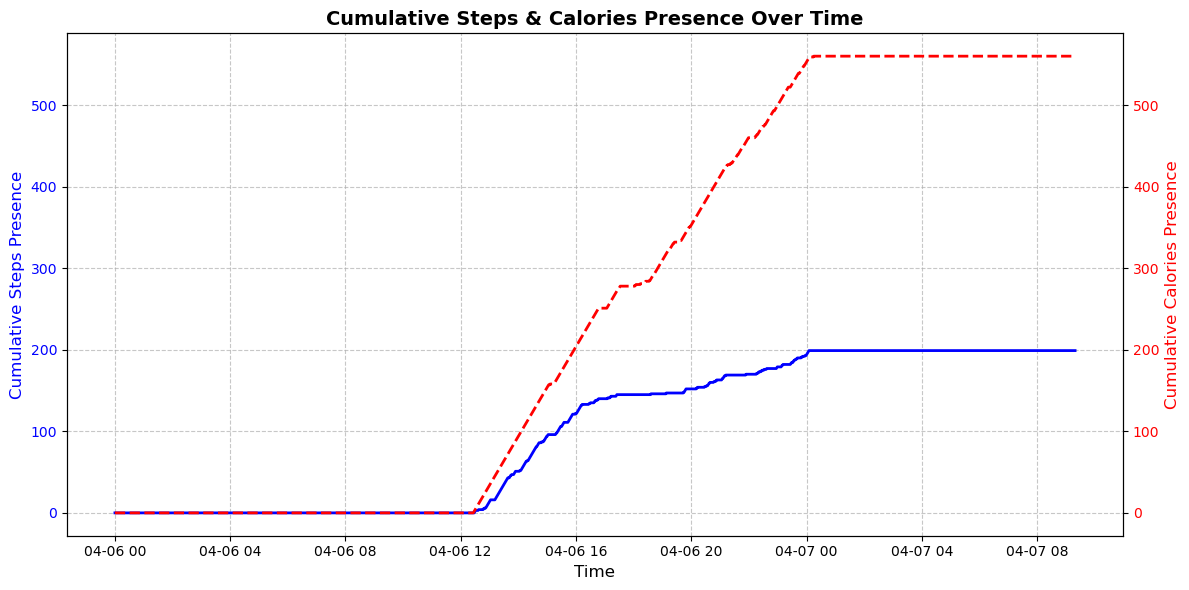

In [ ]:
def load_and_process_data(filename, column_name, num_days=1):
    """Load CSV file, convert time column, filter data, and compute cumulative sum based on min threshold."""
    path = os.path.join(os.getcwd(), filename)
    df = pd.read_csv(path)

    # Convert 'ActivityMinute' to datetime format
    df['ActivityMinute'] = pd.to_datetime(df['ActivityMinute'])

    # Keep only the first 'num_days' of data (1440 minutes/day)
    df_filtered = df.iloc[:2000 * num_days].copy()      #should be :1440, but I used 2000 *1 for beter visualisation

    # Compute the minimum value in the column
    min_value = df_filtered[column_name].min()

    # Create a binary column (1 if value >= min_value, else 0)
    df_filtered[f'{column_name}_ok'] = (df_filtered[column_name] > min_value).astype(int)

    # Create cumulative sum column
    df_filtered[f'{column_name}_sum'] = df_filtered[f'{column_name}_ok'].cumsum()
    
    return df_filtered

def plot_steps_and_calories(steps_df, calories_df):
    """Plot cumulative Steps and Calories presence over time with dual y-axes."""
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot cumulative Steps_ok
    ax1.plot(steps_df['ActivityMinute'], steps_df['Steps_sum'], color='b', linewidth=2, label='Cumulative Steps')
    ax1.set_xlabel('Time', fontsize=12)
    ax1.set_ylabel('Cumulative Steps Presence', fontsize=12, color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    # ax1.set_ylim(0, 650)  
    
    # Create a second y-axis for Calories_ok
    ax2 = ax1.twinx()
    ax2.plot(calories_df['ActivityMinute'], calories_df['Calories_sum'], color='r', linewidth=2, linestyle='dashed', label='Cumulative Calories')
    ax2.set_ylabel('Cumulative Calories Presence', fontsize=12, color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    # ax2.set_ylim(0, 650)

    ax1.set_ylim(ax2.get_ylim())

    # Title and formatting
    plt.title('Cumulative Steps & Calories Presence Over Time', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45)
    ax1.grid(True, linestyle='--', alpha=0.7)

    # Show plot
    plt.tight_layout()
    plt.show()

# Load data
steps_data = load_and_process_data('steps_per_minute.csv', 'Steps')
calories_data = load_and_process_data('calories_per_minute.csv', 'Calories')

# Plot data
plot_steps_and_calories(steps_data, calories_data)
